In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob

In [2]:
nc_files = sorted(glob.glob("C:/Users/aneli/Documents/LOC/PC_casa/Dataset/**/*.nc", recursive=True))

In [3]:
def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -60) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds
    
def check_staircase_exists(ml_h, gl_h): #verifica se os valores são fisicamente válidos (n só se existem)

    valid_ml = np.sum(~np.isnan(ml_h) & (ml_h > 0))
    valid_gl = np.sum(~np.isnan(gl_h) & (gl_h > 0))

    return (valid_ml >= 1) and (valid_gl >= 1)
    
def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim] #p n ter problema d confundir "n" e "Nobs"

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        # SALT FINGER
        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        gl_mask_sf = ds.mask_gl_sf_layer.isel({profile_dim: i}) > 0

        ml_h_sf = ds.ml_h.isel({profile_dim: i}).values[ml_mask_sf.values] #pega os valores onde ml_mask_sf é True 
        gl_h_sf = ds.gl_h.isel({profile_dim: i}).values[gl_mask_sf.values]

        if len(ml_h_sf) > 0 and len(gl_h_sf) > 0:
            staircase_sf[i] = check_staircase_exists(
                ml_h_sf, gl_h_sf
            )

        # DIFFUSIVE CONVECTION
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0
        gl_mask_dc = ds.mask_gl_dc_layer.isel({profile_dim: i}) > 0

        ml_h_dc = ds.ml_h.isel({profile_dim: i}).values[ml_mask_dc.values]
        gl_h_dc = ds.gl_h.isel({profile_dim: i}).values[gl_mask_dc.values]

        if len(ml_h_dc) > 0 and len(gl_h_dc) > 0:
            staircase_dc[i] = check_staircase_exists(
                ml_h_dc, gl_h_dc
            )

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds
    
def plot_variable_row(var_key,
                      xlabel,
                      title,
                      invert=False,
                      bins=30):

    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    axes = axes.flatten()

    # Regimes principais (1 por eixo)
    regimes_main = [
        ("all", "Geral", "gray"),
        ("sf_total", "SF total", "red"),
        ("dc_total", "DC total", "blue"),
    ]

    for ax, (reg_key, reg_label, color) in zip(axes, regimes_main):

        data = data_store[reg_key][var_key]
        data = data[np.isfinite(data)]

        if len(data) > 0:
            ax.hist(data,
                    bins=bins,
                    density=False,
                    alpha=0.6,
                    color=color,
                    label=reg_label)

        # Overlay SF puro sobre SF total
        if reg_key == "sf_total":

            pure = data_store["sf_puro"][var_key]
            pure = pure[np.isfinite(pure)]

            if len(pure) > 0:
                ax.hist(pure,
                        bins=bins,
                        density=False,
                        histtype="step",
                        linewidth=2,
                        color="maroon",
                        label="SF puro")

        # Overlay DC puro sobre DC total
        if reg_key == "dc_total":

            pure = data_store["dc_puro"][var_key]
            pure = pure[np.isfinite(pure)]

            if len(pure) > 0:
                ax.hist(pure,
                        bins=bins,
                        density=False,
                        histtype="step",
                        linewidth=2,
                        color="midnightblue",
                        label="DC puro")
                
        # Overlay misto sobre Geral
        
        if reg_key == "all":

            pure = data_store["misto"][var_key]
            pure = pure[np.isfinite(pure)]

            if len(pure) > 0:
                ax.hist(pure,
                        bins=bins,
                        density=False,
                        histtype="step",
                        linewidth=2,
                        color="darkgreen",
                        label="Misto")
        
        # Ajuste eixo X para espessura e nº camadas
        if var_key in ["h", "n"]:
            ax.set_xlim(0, 35)

        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequência")

        if invert:
            ax.invert_xaxis()

        ax.set_title(reg_label)
        ax.grid(alpha=0.3)
        ax.legend()

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


In [4]:
regimes = [
    "all",
    "sf_total",
    "dc_total",
    "sf_puro",
    "dc_puro",
    "misto"
]

data_store = {}

for r in regimes:
    data_store[r] = {
        "first": [],
        "last": [],
        "h": [],
        "n": [],
        "lat": []
    }

# LOOP PRINCIPAL

for file in nc_files:

    ds = xr.open_dataset(file)
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        continue

    ds = detect_staircases(ds)

    profile_dim = ds.ml_p.dims[0]
    layer_dim   = ds.ml_p.dims[1]

    # Reconstruir topo e base
    top = ds.ml_p - ds.ml_h / 2
    bottom = ds.ml_p + ds.ml_h / 2

    # Máscaras 1D por perfil
    sf_profile = ds.staircase_sf
    dc_profile = ds.staircase_dc

    all_profile      = sf_profile | dc_profile
    sf_total_profile = sf_profile
    dc_total_profile = dc_profile
    sf_puro_profile  = sf_profile & ~dc_profile
    dc_puro_profile  = dc_profile & ~sf_profile
    misto_profile    = sf_profile & dc_profile

    profile_masks = {
        "all": all_profile,
        "sf_total": sf_total_profile,
        "dc_total": dc_total_profile,
        "sf_puro": sf_puro_profile,
        "dc_puro": dc_puro_profile,
        "misto": misto_profile
    }

    # Máscaras por camada
    sf_layer = ds.mask_ml_sf_layer > 0
    dc_layer = ds.mask_ml_dc_layer > 0
    any_layer = sf_layer | dc_layer

    layer_masks = {
        "all": any_layer,
        "sf_total": sf_layer,
        "dc_total": dc_layer,
        "sf_puro": sf_layer,
        "dc_puro": dc_layer,
        "misto": any_layer
    }

    # LOOP SOBRE REGIMES

    for regime in regimes:

        prof_mask = profile_masks[regime]
        layer_mask_base = layer_masks[regime]

        # expandir para 2D
        prof_mask_2d = prof_mask.broadcast_like(ds.ml_p)

        # aplicar máscara final
        final_mask = layer_mask_base & prof_mask_2d

        # first e last
        first_vals = top.where(final_mask).min(dim=layer_dim).values
        last_vals  = bottom.where(final_mask).max(dim=layer_dim).values

        data_store[regime]["first"].extend(
            first_vals[np.isfinite(first_vals)]
        )

        data_store[regime]["last"].extend(
            last_vals[np.isfinite(last_vals)]
        )
        
        # espessura das camadas
        h_vals = ds.ml_h.where(final_mask).values.flatten()
        data_store[regime]["h"].extend(
            h_vals[np.isfinite(h_vals)]
        )

        # número de camadas por perfil
        n_vals = final_mask.sum(dim=layer_dim).values
        data_store[regime]["n"].extend(
            n_vals[n_vals > 0]
        )

        # latitude
        lat_vals = ds.lat.where(prof_mask).values
        data_store[regime]["lat"].extend(
            lat_vals[np.isfinite(lat_vals)]
        )

# CONVERTER PARA NUMPY

for regime in regimes:
    for var in data_store[regime]:
        data_store[regime][var] = np.array(
            data_store[regime][var]
        )

print("Processamento concluído.")

Processamento concluído.


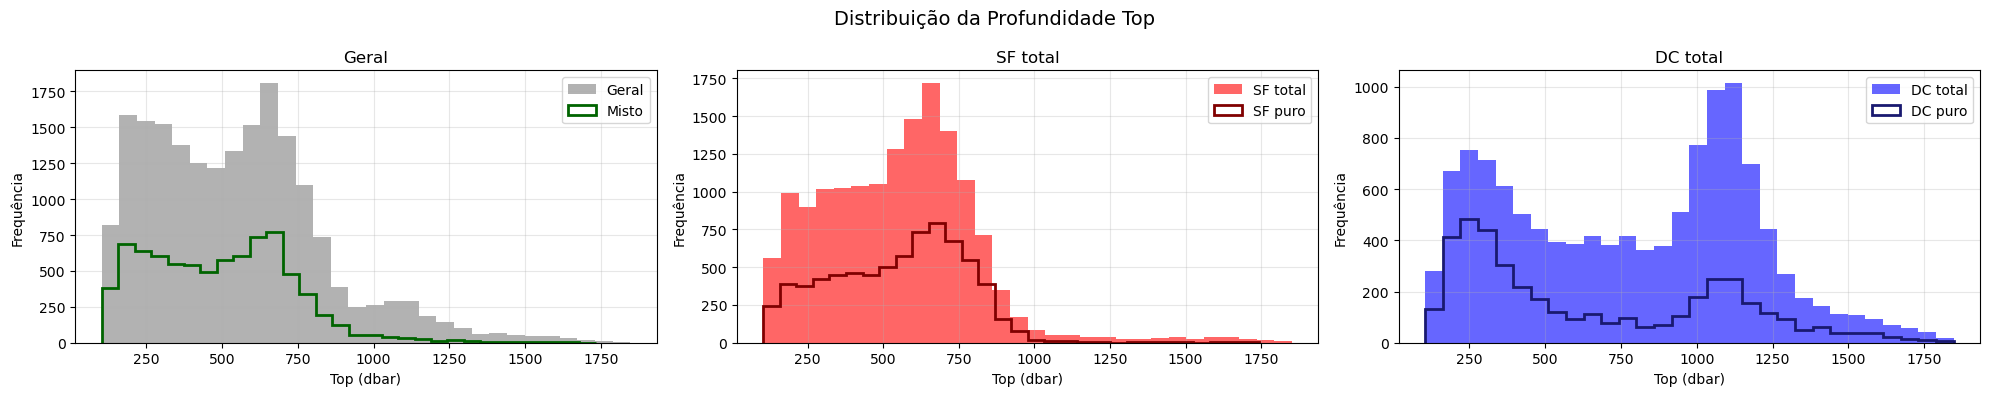

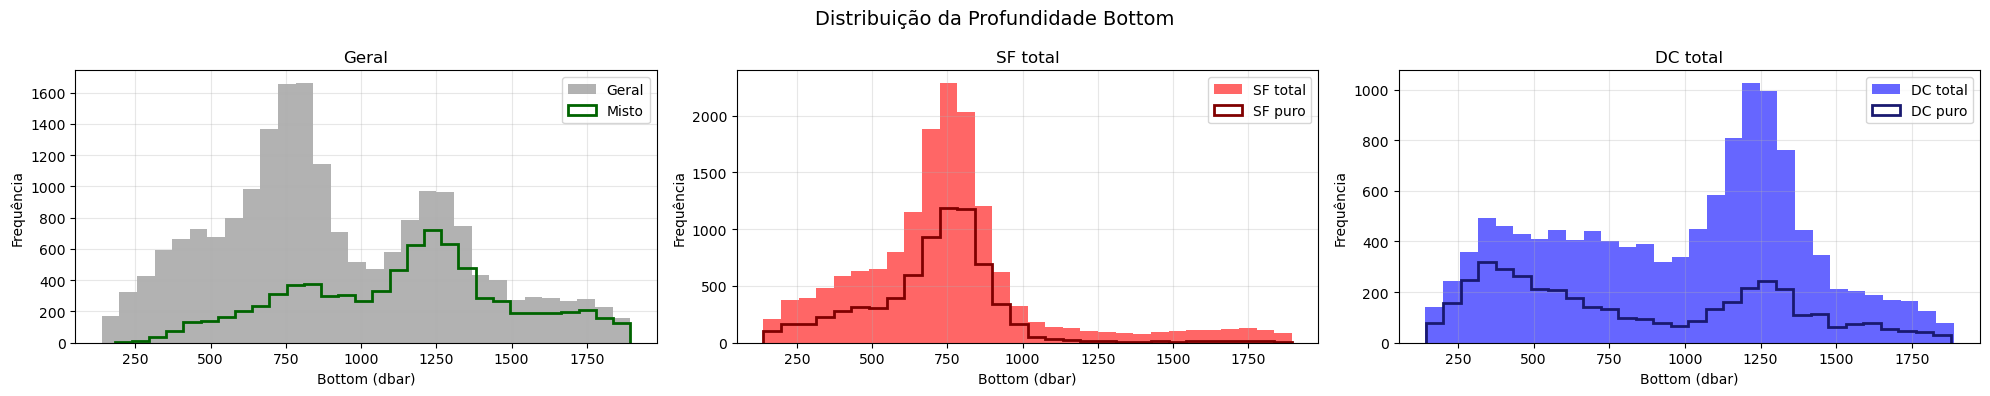

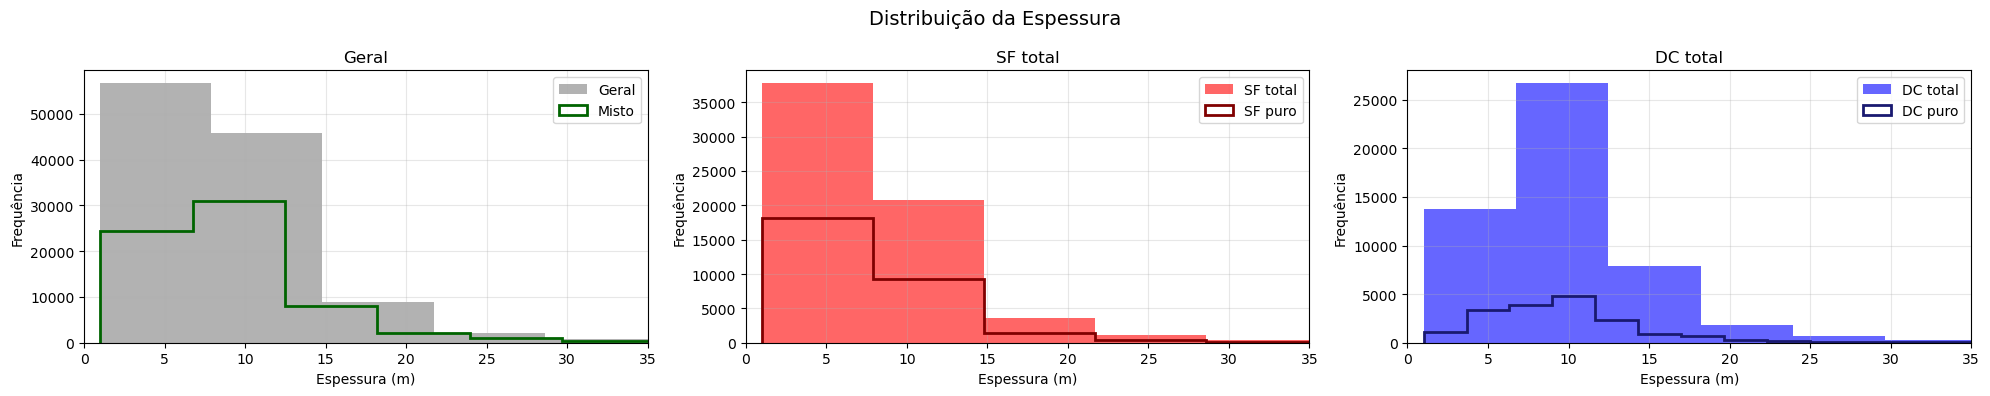

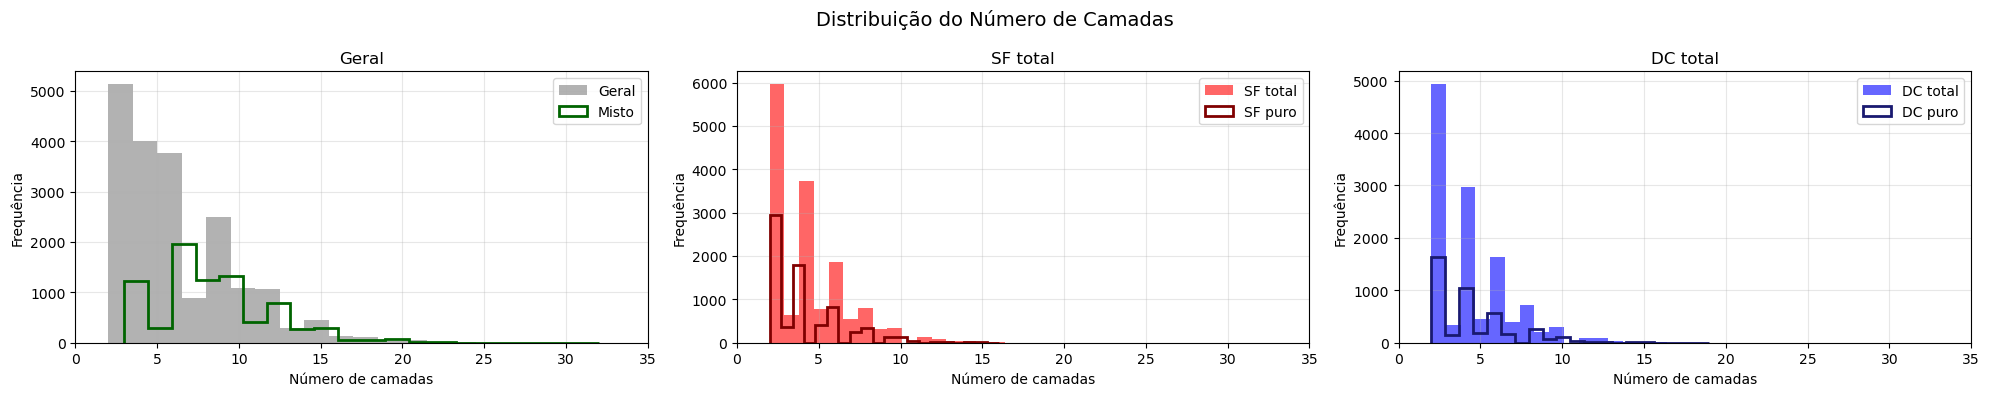

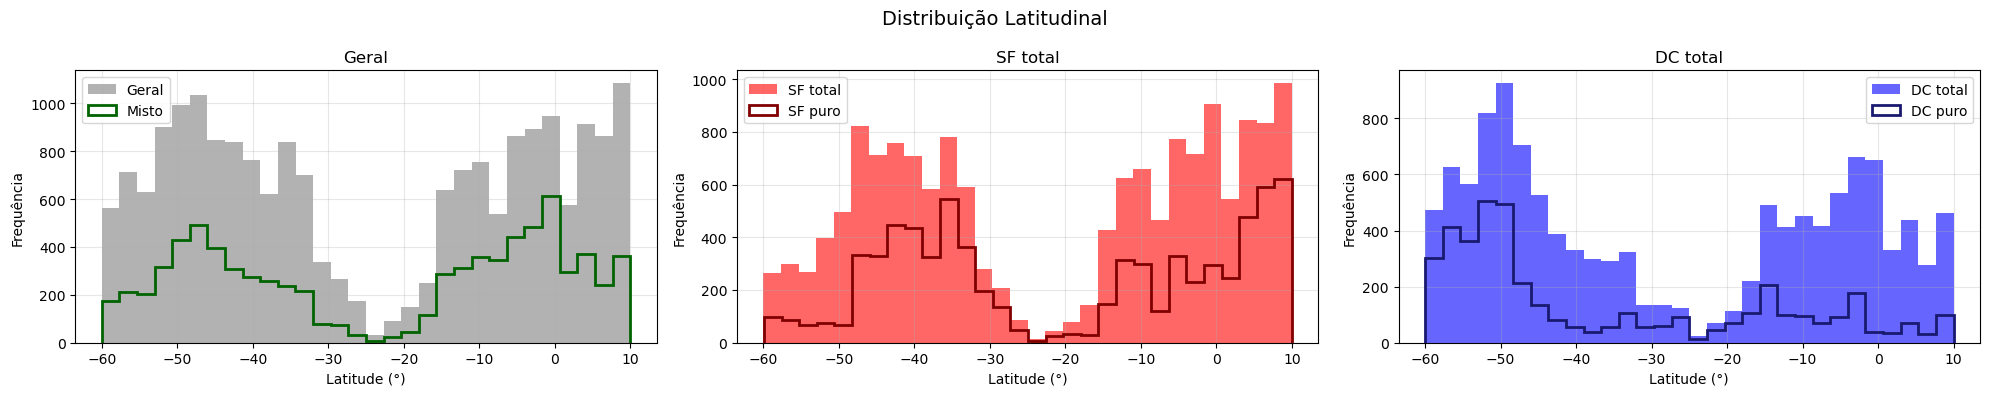

In [6]:
plot_variable_row(
    var_key="first",
    xlabel="Top (dbar)",
    title="Distribuição da Profundidade Top",
)

plot_variable_row(
    var_key="last",
    xlabel="Bottom (dbar)",
    title="Distribuição da Profundidade Bottom",
)

plot_variable_row(
    var_key="h",
    xlabel="Espessura (m)",
    title="Distribuição da Espessura"
)

plot_variable_row(
    var_key="n",
    xlabel="Número de camadas",
    title="Distribuição do Número de Camadas",
    bins=20
)

plot_variable_row(
    var_key="lat",
    xlabel="Latitude (°)",
    title="Distribuição Latitudinal",
    bins=30
)